# Matrix Multiplication on CPU: Optimizations and Insights

In this notebook, we explore CPU implementations of matrix multiplication.
We analyze various optimization techniques including:

- **Naive implementation**
- **Tiled execution**
- **Unrolled loop**

Each method aims to reduce global memory access and increase computation throughput.

## Preparing the required packages and initialisations


In [ ]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def benchmark(func, A, B, label, runs=3):
    times = []
    for _ in range(runs):
        torch.cuda.empty_cache()
        start = time.time()
        _ = func(A, B)
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        times.append(time.time() - start)
    avg_time = sum(times) / len(times)
    print(f"{label}: {avg_time:.4f} seconds")
    return avg_time


## Naive implementation

In [ ]:
def matmul_naive_cpu(A, B):
    """Performs matrix multiplication using a naive algorithm."""
    C = np.zeros((A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                C[i, j] += A[i, k] * B[k, j]
    return C


## Tiled execution

In [ ]:
def matmul_tiled_cpu(A, B, tile_size=32):
    """Performs matrix multiplication with tiling."""
    C = np.zeros((A.shape[0], B.shape[1]))
    for i in range(0, A.shape[0], tile_size):
        for j in range(0, B.shape[1], tile_size):
            for k in range(0, A.shape[1], tile_size):
                for ii in range(i, min(i + tile_size, A.shape[0])):
                    for jj in range(j, min(j + tile_size, B.shape[1])):
                        for kk in range(k, min(k + tile_size, A.shape[1])):
                            C[ii, jj] += A[ii, kk] * B[kk, jj]
    return C

## Unrolled loop

In [ ]:
def matmul_unrolled_cpu(A, B):
  """Performs matrix multiplication with loop unrolling."""
  C = np.zeros((A.shape[0], B.shape[1]))
  for i in range(A.shape[0]):
    for j in range(B.shape[1]):
      sum_val = 0
      for k in range(0, A.shape[1], 4): # Unroll by 4
        sum_val += A[i, k] * B[k, j]
        sum_val += A[i,k+1] * B[k+1, j]
        sum_val += A[i,k+2] * B[k+2, j]
        sum_val += A[i,k+3] * B[k+3, j]
      C[i, j] = sum_val
  return C

## Benchmarking

CPU (unrolled): 0.5274 seconds
CPU (tiled): 0.8656 seconds
CPU (naive): 0.9633 seconds


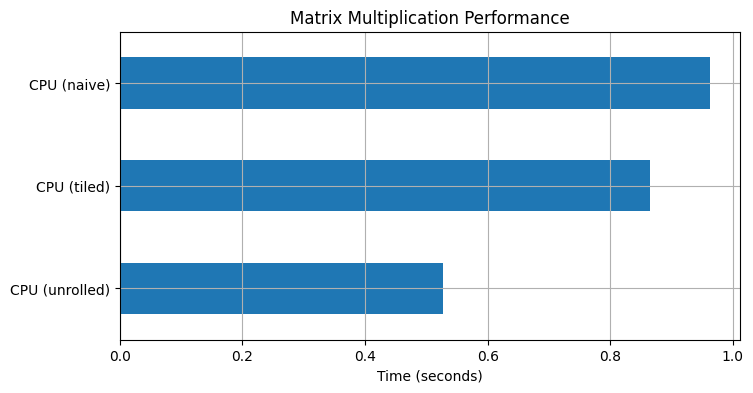

In [ ]:
# Problem size (adjust N for bigger test)
N = 32
assert(32 % 4 == 0) # To ensure nothing wrong happens with the unrolling
A = torch.randn(N, N)
B = torch.randn(N, N)

results = {}

# Run benchmarks
results['CPU (unrolled)'] = benchmark(matmul_unrolled_cpu, A, B, 'CPU (unrolled)')
results['CPU (tiled)'] = benchmark(matmul_tiled_cpu, A, B, 'CPU (tiled)')
results['CPU (naive)'] = benchmark(matmul_naive_cpu, A, B, 'CPU (naive)')

# Display results
df = pd.DataFrame.from_dict(results, orient='index', columns=['Execution Time (s)'])
df.plot(kind='barh', legend=False, figsize=(8, 4), title='Matrix Multiplication Performance')
plt.xlabel('Time (seconds)')
plt.grid(True)
plt.show()
